<a href="https://colab.research.google.com/github/esgantivar/qmc/blob/torch/examples/torch/dmkdc-tn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install qmc if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/esgantivar/qmc.git@torch -q
else:
    import sys
    sys.path.insert(0, '../../')

In [4]:
import torch
import numpy as np
import tensornetwork as tn
from qmc.torch.models import DMKDClassifierTNSGD
from qmc.torch.utils import get_moons
import torch.nn.functional as F

In [5]:
tn.set_default_backend('pytorch')

In [6]:
%matplotlib inline
import numpy as np
import pylab as pl

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    X = X.numpy()
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return (clf(torch.tensor(X, dtype=torch.float))).detach().numpy()[:, 1]
    return pred_fun

In [7]:
(X, y), (x_train, y_train), (x_test, y_test) = get_moons()

In [8]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.nn.functional.one_hot(torch.tensor(y_train)).to(torch.float)
y_test =  torch.nn.functional.one_hot(torch.tensor(y_test)).to(torch.float)

In [23]:
tn_dmkdc = DMKDClassifierTNSGD(
    input_dim=2,
    dim_x=150,
    num_classes=2,
    num_eig=50,
    gamma=20,
    random_state=17
)

In [24]:
optimizer = torch.optim.Adam(tn_dmkdc.parameters(), lr=0.5)
loss_fn = torch.nn.BCELoss()

In [25]:
for _ in range(20):
    correct = 0
    y_pred = tn_dmkdc(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    for i in range(len(y_pred)):
        if torch.argmax(y_pred[i]) == torch.argmax(y_train[i]):
            correct += 1
    print(correct/len(y_pred))
    loss.backward()
    optimizer.step()

0.658955223880597
0.9313432835820895
0.9537313432835821
0.9514925373134329
0.9611940298507463
0.9694029850746269
0.9656716417910448
0.9582089552238806
0.9522388059701492
0.9537313432835821
0.9641791044776119
0.9686567164179104
0.9701492537313433
0.9731343283582089
0.9746268656716418
0.9746268656716418
0.9716417910447761
0.9723880597014926
0.9723880597014926
0.9746268656716418


In [26]:
out = tn_dmkdc(x_test)
out[:10]

tensor([[0.0441, 0.9559],
        [0.8345, 0.1655],
        [0.0538, 0.9462],
        [0.0524, 0.9476],
        [0.8305, 0.1695],
        [0.9488, 0.0512],
        [0.1201, 0.8799],
        [0.0493, 0.9507],
        [0.9521, 0.0479],
        [0.0670, 0.9330]], grad_fn=<SliceBackward>)

0.00011571883 0.00011571883
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


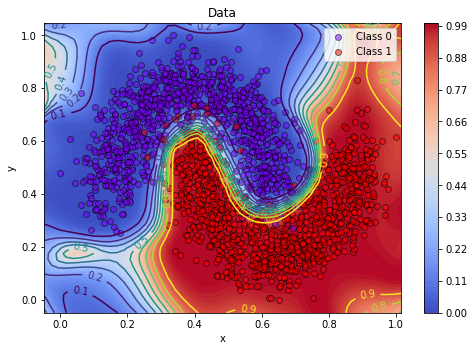

In [27]:
pl.figure(figsize = (8,16/3))    
plot_decision_region(x_test, gen_pred_fun(dmkdc))
plot_data(X, y)